# Mini Project: Solving the 1D Heat Equation using Physics-Informed Neural Networks

#### Background:
The one-dimensional heat equation is given by:

$ \frac{\partial u}{\partial t} = D \frac{\partial^2 u}{\partial x^2} $

where $ u(x, t) $ is the temperature distribution over space and time, and $D$ is the thermal diffusivity of the material.
Suppose the domain is $ x \in [0, 1] $ and $ t \in [0,1] $, with initial condition $ u(x, 0) = \sin(\pi x) $ and boundary conditions $ u(0, t) = u(1, t) = 0 $.

The exact solution to this problem is:

$ u(x, t) = e^{-\pi^2 D t} \sin(\pi x) $

### Preliminary:
Verify the solution is correct, and visualize the temperature distribution over time

#### Data Preparation
We pick a value for the thermal diffusivity, say $D = 1$.

Let's create a grid of points in the domain $ x \in [0, 1] $ and $ t \in [0, 1] $.
Let $\Delta t$ be the time step size and $\Delta x$ be the spatial step size.
That is, $x_i = 0, \Delta x, 2\Delta x, \ldots, 1$ and $t_j = 0, \Delta t, 2\Delta t, \ldots, 1$.

For now, set $\Delta t = \Delta x = 0.1$.


Generate a dataset of input-output pairs $\{x_i, t_j, u(x_i, t_j)\}$ using the exact solution.


#### Set up PINN
Build a neural network that takes $(x, t)$ as input and outputs the predicted temperature $u_W(x, t)$.

To enforce the boundary condition, we represent the solution by $u_W(x,t) = u(x, 0) * t + x(1-x) t N_W(x,t)$ where $N_W(x,t)$ is the output of a fully connected neural network, and $W$ represents the weights of the network.

#### Solve the forward problem
Use the ground truth parameter D to solve the forward problem using the PINN by minmizing the residual loss.

Evaluate the accuracy of the solution by computing the mean squared error between predicted temperature distribution with the exact solution on the grid points.


#### Solve the inverse problem
Make the thermal diffusivity $D$ a trainable parameter. We will solve the inverse problem by minimizing the data loss and the residual loss.

Look at the accuracy of the predicted $D$ by comparing it with the ground truth value.


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset, random_split
from mpl_toolkits.mplot3d import Axes3D
import time

3.7.1


In [ ]:
# Importing libraries for Google Drive access
import os
from google.colab import drive

# Mount Google Drive
#drive.mount('/content/drive')

# Set up location for storing images
#images_dir = '/content/drive/MyDrive/heat_pinn_data/general_runs'
#images_dir = '/content/drive/MyDrive/cfl_density_0.1/D_0.1'

In [ ]:
# Data Preparation

delta_X = 0.1
delta_T = 0.1
D = 0.01

x = torch.linspace(0, 1, round(1/delta_X))
t = torch.linspace(0, 1, round(1/delta_T))

X_grid, T_grid = torch.meshgrid(x, t, indexing='ij') # matrix of values
X_flat = X_grid.flatten().view(-1, 1)
T_flat = T_grid.flatten().view(-1, 1)

def exact(x, t):
    if not isinstance(x, torch.Tensor):
        x = torch.tensor(x)
    if not isinstance(t, torch.Tensor):
        t = torch.tensor(t)
    return torch.sin(torch.pi * x) * torch.exp(-torch.pi**2 * D * t)

U = exact(X_flat, T_flat)

dataset = TensorDataset(X_flat, T_flat, U)
print(U.shape)


torch.Size([100, 1])


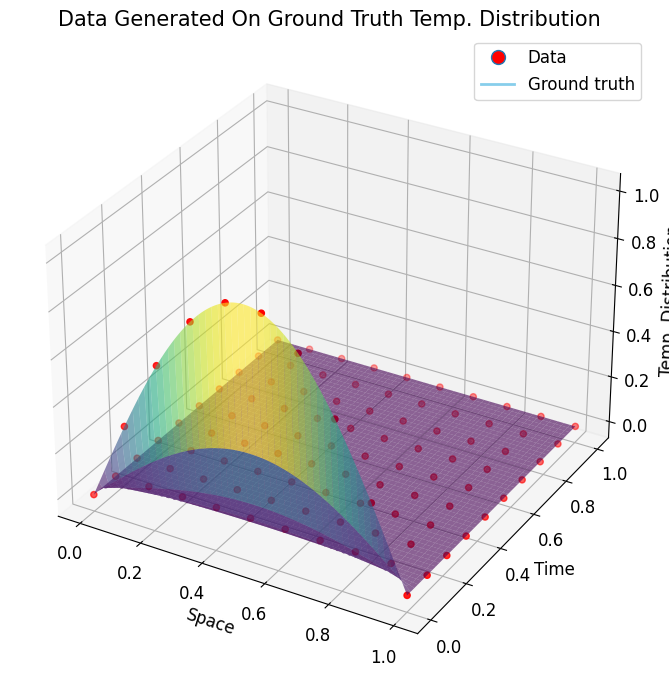

In [ ]:
# Visualize dataset

plt.rcParams.update({'font.size': 12})

X_overall = torch.linspace(0, 1, 300)
T_overall = torch.linspace(0, 1, 300)

X_overall_grid, T_overall_grid = torch.meshgrid(X_overall, T_overall, indexing='ij')

X_overall_flat = X_overall_grid.flatten().view(-1, 1)
T_overall_flat = T_overall_grid.flatten().view(-1, 1)


fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X_overall_grid.numpy(), T_overall_grid.numpy(), exact(X_overall_grid, T_overall_grid).numpy(), cmap='viridis', alpha=0.6)
ax.scatter(X_grid.numpy(), T_grid.numpy(), U.numpy(), c='r', marker='o')
ax.set_xlabel('Space')
ax.set_ylabel('Time')
ax.set_zlabel('Temp. Distribution')
ax.set_title('Data Generated On Ground Truth Temp. Distribution', fontsize=15)

proxy_artists = [
    plt.Line2D([0], [0], linestyle="", marker='o', markersize=10, markerfacecolor='r'),
    plt.Line2D([0], [0], linestyle="-", linewidth=2, color='skyblue')
]
ax.legend(proxy_artists, ['Data', 'Ground truth'])

plt.tight_layout()
#plt.savefig(f"{images_dir}/heat_3d_datagt.eps")
plt.show()



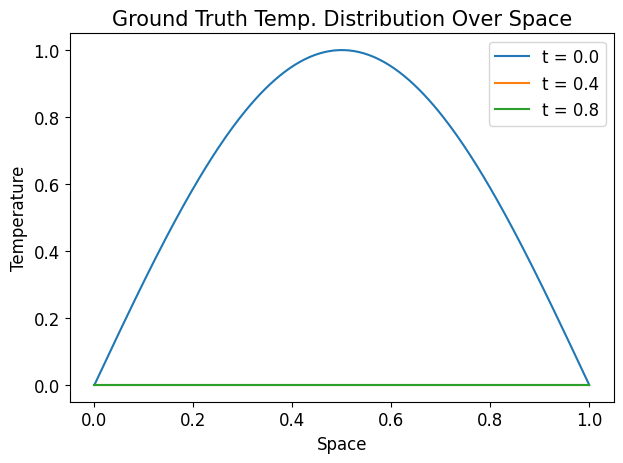

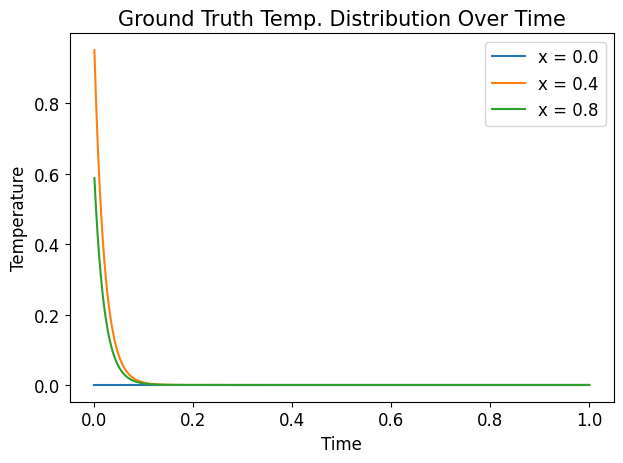

In [ ]:
#Visualizing temperature distribution over time
vals = [0.0, 0.4, 0.8]

T_vals = [torch.full_like(X_overall, val) for val in vals]
X_vals = [torch.full_like(X_overall, val) for val in vals]

for i in range(len(vals)):
    plt.plot(X_overall.detach().numpy(), exact(X_overall, X_vals[i]).detach().numpy(), label = f't = {vals[i]}')
plt.title(f'Ground Truth Temp. Distribution Over Space', fontsize=15)
plt.tight_layout()
plt.xlabel('Space')
plt.ylabel('Temperature')
plt.legend()
plt.tight_layout()
#plt.savefig(f"{images_dir}/heat_temp_space.eps")
plt.show()


for i in range(len(vals)):
    plt.plot(T_overall.detach().numpy(), exact(X_vals[i], T_overall).detach().numpy(), label = f'x = {vals[i]}')
plt.xlabel('Time')
plt.ylabel('Temperature')

plt.title('Ground Truth Temp. Distribution Over Time', fontsize=15)
plt.legend()


plt.tight_layout()
#plt.savefig(f"{images_dir}/heat_temp_time.eps")
plt.show()

In [ ]:
#set up net class

class Net(nn.Module):
    def __init__(self, d, w):
        super(Net, self).__init__()

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(2, w))

        for i in range(d-2):
          self.layers.append(nn.Linear(w, w))

        self.layers.append(nn.Linear(w, 1))


    def forward(self, x, t):
        x = x.reshape(-1, 1)
        t = t.reshape(-1, 1)
        combined_input = torch.cat((x, t), dim=1)
        out = combined_input
        for layer in self.layers[:-1]:
           out = torch.tanh(layer(out)) # tanh activation
        out = self.layers[-1](out)

        # Transformation to enforce boundary and initial condition
        u_x0 = torch.sin((torch.pi*x))
        u = u_x0 + t*out*x*(1-x)
        return u

    def compute_derivatives(self, x_input, t_input):
      du_dt = torch.autograd.grad(outputs=self(x_input,t_input), inputs=t_input, grad_outputs=torch.ones_like(self(x_input,t_input)), create_graph=True, retain_graph=True)[0]
      du_dx = torch.autograd.grad(outputs=self(x_input,t_input), inputs=x_input, grad_outputs=torch.ones_like(self(x_input,t_input)), create_graph=True, retain_graph=True)[0]
      d2u_dx2 = torch.autograd.grad(outputs=du_dx, inputs=x_input, grad_outputs=torch.ones_like(du_dx), create_graph=True, retain_graph=True)[0]
      return du_dt, d2u_dx2
d, w = 5, 80
model = Net(d, w)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

In [ ]:
# Sets up batches in DataLoader
batch_size = X_flat.shape[0]
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
def train(model, criterion, optimizer, epochs, lamda_reg):
    losses = []

    for epoch in range(epochs): # iterating through epochs
        model.train()

        for x, t, u in dataloader: # iteration through batches
          x.requires_grad = True
          t.requires_grad = True
          optimizer.zero_grad()
          outputs = model(x, t)

          # Residual loss
          du_dt, d2u_dx2 = model.compute_derivatives(x, t)

          res = du_dt - D*d2u_dx2 # residual
          total_loss = res.pow(2).mean() # penalizing high values

          total_loss.backward()
          optimizer.step()

          losses.append(total_loss.item())

        if epoch % 100 == 0:
          print(f"Epoch {epoch+1}, total: {total_loss.item()}")

    return losses

In [ ]:
epochs = 5000
lambda_reg = 1
st = time.time()
losses = train(model, criterion, optimizer, epochs, lambda_reg)
et = time.time()
print(et-st)

Epoch 1, total: 1100.1165771484375
Epoch 101, total: 374.5434875488281
Epoch 201, total: 164.25189208984375
Epoch 301, total: 128.94134521484375
Epoch 401, total: 113.59614562988281
Epoch 501, total: 104.82628631591797
Epoch 601, total: 97.64962768554688
Epoch 701, total: 92.23675537109375
Epoch 801, total: 87.08416748046875
Epoch 901, total: 83.53262329101562
Epoch 1001, total: 80.90859985351562
Epoch 1101, total: 80.32785034179688
Epoch 1201, total: 77.42748260498047
Epoch 1301, total: 76.31777954101562
Epoch 1401, total: 75.49151611328125
Epoch 1501, total: 74.52229309082031
Epoch 1601, total: 73.5078353881836
Epoch 1701, total: 72.37728881835938
Epoch 1801, total: 71.486572265625
Epoch 1901, total: 70.06289672851562
Epoch 2001, total: 68.85203552246094
Epoch 2101, total: 67.63549041748047
Epoch 2201, total: 66.3656234741211
Epoch 2301, total: 65.11952209472656
Epoch 2401, total: 63.820213317871094
Epoch 2501, total: 69.1432113647461
Epoch 2601, total: 61.255069732666016
Epoch 2701,

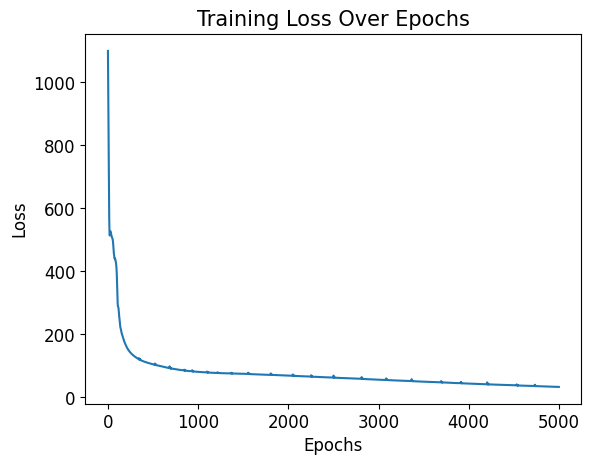

In [ ]:
# Plots the training loss over all epochs
plt.plot(np.arange(len(losses)), losses)
plt.title('Training Loss Over Epochs', fontsize=15)
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.savefig(f"{images_dir}/heat_loss_epochs.eps")
plt.show()

In [ ]:
#calculate MSE using data

u_overall = model(X_overall_flat, T_overall_flat)
u_ground_truth = exact(X_overall_flat, T_overall_flat)

mse_overall = criterion(u_overall, u_ground_truth).item()

u_dp = model(X_flat, T_flat)
u_gt_dp = exact(X_flat, T_flat)
mse_dp = criterion(u_dp, u_gt_dp).item()

print(f"Overall MSE: {mse_overall}")
print(f'Data Point MSE: {mse_dp}')
print(f'Total Loss: {losses[-1]}')

MSE over [0, 1]: 0.0099120968952775
Total Loss: 33.07329559326172


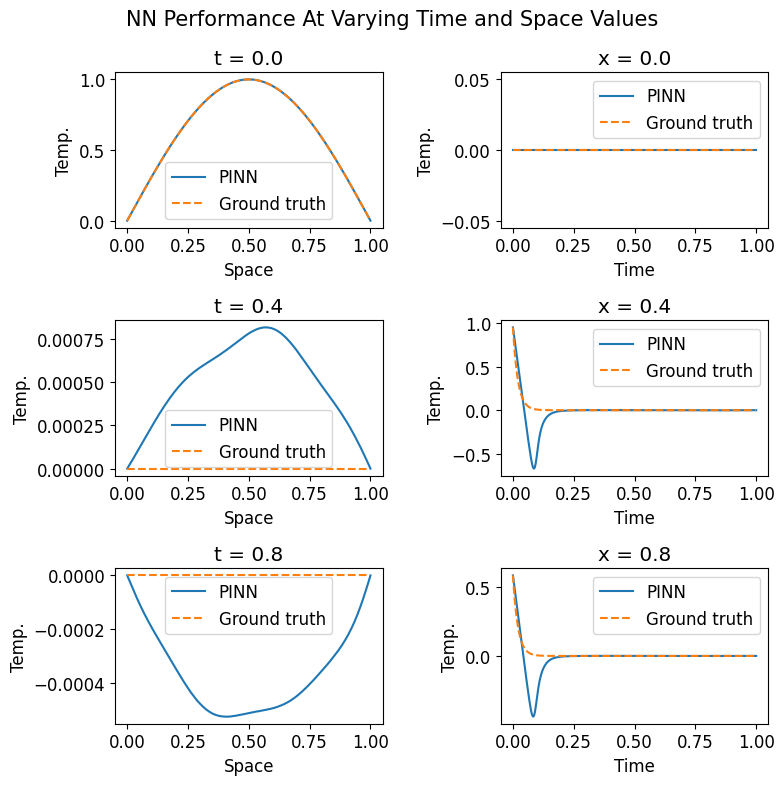

In [ ]:
# Plots neural network with ground truth and data

plt.figure(figsize=(8, 8))
subplot_indexes=[1, 3, 5]
for i in range(len(T_vals)):
    plt.subplot(3, 2, subplot_indexes[i])
    plt.plot(X_overall.detach().numpy(), model(X_overall, T_vals[i]).detach().numpy(), label = 'PINN')
    plt.plot(X_overall.detach().numpy(), exact(X_overall, T_vals[i]).detach().numpy(), label = 'Ground truth', linestyle = '--')
    plt.title(f't = {vals[i]}')

    plt.xlabel('Space')
    plt.ylabel('Temp.')

    plt.legend()

for i in range(len(X_vals)):
  plt.subplot(3, 2, subplot_indexes[i]+1)
  plt.plot(T_overall.detach().numpy(), model(X_vals[i], T_overall).detach().numpy(), label = 'PINN')
  plt.plot(T_overall.detach().numpy(), exact(X_vals[i], T_overall).detach().numpy(), label = 'Ground truth', linestyle = '--')
  plt.title(f'x = {vals[i]}')

  plt.xlabel('Time')
  plt.ylabel('Temp.')

  plt.legend()

plt.suptitle('NN Performance At Varying Time and Space Values', fontsize=15)
plt.tight_layout()
#plt.savefig(f"{images_dir}/heat_pinn_time_space.eps")
plt.show()

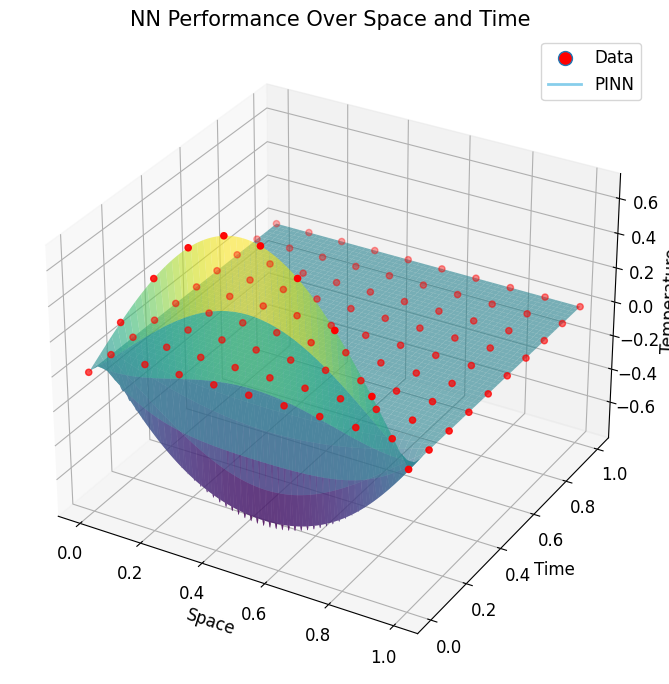

In [ ]:
# Plotting neural network with data
pinn_perf = plt.figure(figsize=(7, 7))
ax = pinn_perf.add_subplot(111, projection='3d')

# Scatter plot for exact data
exact_data = ax.scatter(X_grid.numpy(), T_grid.numpy(), exact(X_grid, T_grid).numpy(), color='r', label='Data')

# Surface plot for PINN predictions
predictions = model(X_overall_grid.reshape(-1, 1), T_overall_grid.reshape(-1,1)).reshape(X_overall_grid.shape).detach().numpy()
pinn_surf = ax.plot_surface(X_overall_grid.detach().numpy(), T_overall_grid.detach().numpy(), predictions, cmap='viridis', alpha=0.6, label='PINN')

# Legend setup
proxy_artists = [
    plt.Line2D([0], [0], linestyle="", marker='o', markersize=10, markerfacecolor='r'),
    plt.Line2D([0], [0], linestyle="-", linewidth=2, color='skyblue')
]
ax.legend(proxy_artists, ['Data', 'PINN'])

# Adjust z-axis limits
z_min, z_max = ax.get_zlim()
ax.set_zlim(z_min, z_min + 0.8 * (z_max - z_min))

# Labels and title
ax.set_xlabel('Space')
ax.set_ylabel('Time')
ax.set_zlabel('Temperature')
ax.set_title('NN Performance Over Space and Time', fontsize=15)

# Adjust layout
plt.subplots_adjust(top=0.5)
plt.tight_layout()

# Save and show plot
#plt.savefig(f"{images_dir}/heat_pinndata.eps")
plt.show()

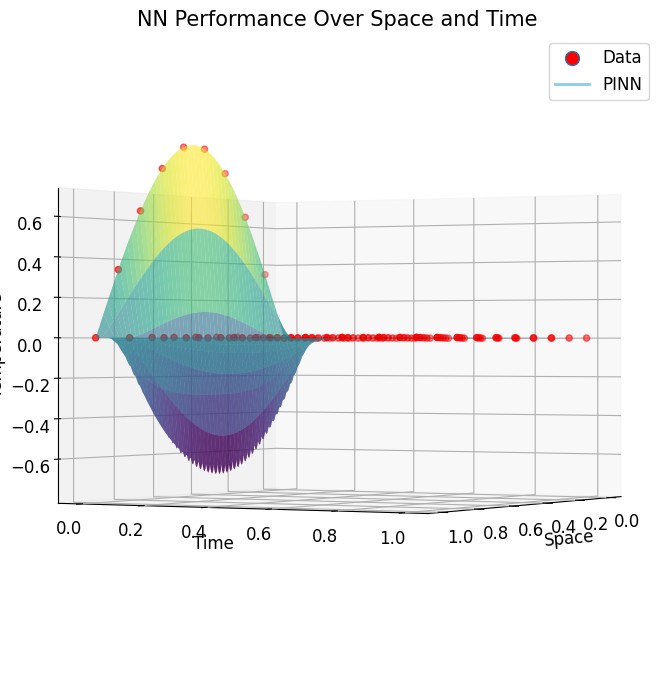

In [ ]:
# Plotting neural network with data
pinn_perf = plt.figure(figsize=(7, 7))
ax = pinn_perf.add_subplot(111, projection='3d')

# Scatter plot for exact data
exact_data = ax.scatter(X_grid.numpy(), T_grid.numpy(), exact(X_grid, T_grid).numpy(), color='r', label='Data')

# Surface plot for PINN predictions
predictions = model(X_overall_grid.reshape(-1, 1), T_overall_grid.reshape(-1,1)).reshape(X_overall_grid.shape).detach().numpy()
pinn_surf = ax.plot_surface(X_overall_grid.detach().numpy(), T_overall_grid.detach().numpy(), predictions, cmap='viridis', alpha=0.6, label='PINN')

# Legend setup
proxy_artists = [
    plt.Line2D([0], [0], linestyle="", marker='o', markersize=10, markerfacecolor='r'),
    plt.Line2D([0], [0], linestyle="-", linewidth=2, color='skyblue')
]
ax.legend(proxy_artists, ['Data', 'PINN'])

# Adjust z-axis limits
z_min, z_max = ax.get_zlim()
ax.set_zlim(z_min, z_min + 0.8 * (z_max - z_min))

# Labels and title
ax.set_xlabel('Space')
ax.set_ylabel('Time')
ax.set_zlabel('Temperature')
ax.set_title('NN Performance Over Space and Time', fontsize=15)

# Adjust layout
ax.view_init(elev=0, azim=30)
plt.subplots_adjust(top=0.5)
plt.tight_layout()

# Save and show plot
#plt.savefig(f"{images_dir}/heat_pinndata.eps")
plt.show()

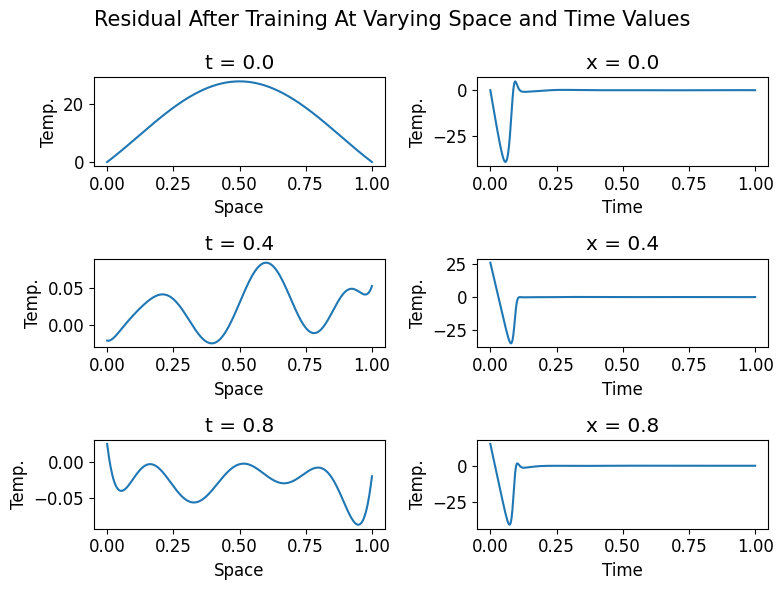

In [ ]:
plt.figure(figsize=(8, 6))

X_overall.requires_grad=True
T_overall.requires_grad=True

for i in range(len(T_vals)):
    T_vals[i].requires_grad=True
    plt.subplot(3, 2, subplot_indexes[i])
    du_dt, d2u_dx2 =model.compute_derivatives(X_overall, T_vals[i])
    residual = du_dt - D*d2u_dx2

    plt.plot(X_overall.detach().numpy(), residual.detach().numpy())
    plt.title(f't = {vals[i]}')

    plt.xlabel('Space')
    plt.ylabel('Temp.')

for i in range(len(X_vals)):
    X_vals[i].requires_grad=True
    plt.subplot(3, 2, subplot_indexes[i]+1)
    du_dt, d2u_dx2 =model.compute_derivatives(X_vals[i], T_overall)
    residual = du_dt - D*d2u_dx2

    plt.plot(X_overall.detach().numpy(), residual.detach().numpy())
    plt.title(f'x = {vals[i]}')

    plt.xlabel('Time')
    plt.ylabel('Temp.')


plt.suptitle('Residual After Training At Varying Space and Time Values', fontsize=15)
plt.tight_layout()
#plt.savefig(f"{images_dir}/residual.eps") # Saves figure to Google Drive
plt.show()

In [ ]:
# # 4 LAYERS AND VARYING NEURONS

# # Array for models with different numbers of layers and neurons
# models_ln = []
# # Array indicating number of layers and neurons. Final element is whether to make the words 'layer' and 'neuron' plural
# ln = [[4, 10], [4, 20], [4, 40], [4, 60], [4, 80]]

# # Creating and training models with specific architectures
# for i in range(5):
#   model_test = Net(ln[i][0], ln[i][1]) # Defines a model with corresponding layers and neurons
#   optimizer = optim.Adam(model_test.parameters()) # Optimizer

#   start_time = time.time()

#   l = train(model_test, criterion, optimizer, 2500, 1) # Trains network

#   end_time = time.time()

#   print(f'Time for ({ln[i][0]}, {ln[i][1]}): ' + str(end_time-start_time))

#   models_ln.append([model_test, optimizer, l]) # Adds model to array for future use


In [ ]:
# # VISUALIZING AND QUANTIFYING ERRORS OF DIFFERENT MODELS

# plt.figure(figsize=(8, 8)) # figure

# # Plotting at different t values
# for t in range(len(T_vals)):
#   plt.subplot(3, 1, t+1)

#   # Looping through models
#   for i in range(5):

#     model_i = models_ln[i][0] # Accesses each model

#     # Plots each model against ground truth function
#     plt.plot(X_overall.detach().numpy(), model_i(X_overall, T_vals[t]).detach().numpy(), label=f'{ln[i][0]} layers, {ln[i][1]} neurons per layer')

#     plt.xlabel('Space')
#     plt.ylabel('Temp.')

#   plt.plot(X_overall.detach().numpy(), exact(X_overall, T_vals[t]).detach().numpy(), label='Ground truth', linestyle='--')
#   plt.title(f't = {vals[t]}')
#   plt.legend()
# plt.suptitle('NN Performance With Varying Neurons Over Space')
# plt.tight_layout()
# plt.savefig(f"{images_dir}/heat_varyingneuronst.eps") # Saves figure to Google Drive
# plt.show()




In [ ]:
# plt.figure() # for constant x plot
# # Printing errors for different configurations
# for i in range(5):
#   print(f'MSE for {ln[i][0]} layers, {ln[i][1]} neurons per layer: ' + str(criterion(models_ln[i][0](X_overall_flat, T_overall_flat), u_ground_truth).item()))
#   print(f'Total Loss for {ln[i][0]} layers, {ln[i][1]} neurons per layer: '+ str(models_ln[i][2][-1]))


#   # Plot networks and ground truth when t is varying
#   plt.plot(T_overall, models_ln[i][0](x_fixed, T_overall).detach().numpy(), label = f'{ln[i][0]} layers, {ln[i][1]} neurons per layer')

#   plt.xlabel('Time')
#   plt.ylabel('Temperature')
#   plt.title('NN Performance With Varying Neurons When x = 0.5')


# plt.plot(T_overall, exact(x_fixed, T_overall).detach().numpy(), label = 'Ground truth', linestyle = '--')
# plt.legend()
# plt.tight_layout()
# plt.savefig(f"{images_dir}/heat_varyingneuronsx.eps") # Saves figure to Google Drive
# plt.show()

In [ ]:
# # 60 NEURONS AND VARYING LAYERS

# # Array for models with different numbers of layers and neurons
# models_ln2 = []
# # Array indicating number of layers and neurons. Final element is whether to make the words 'layer' and 'neuron' plural
# ln2 = [[2, 80], [3, 80], [4, 80], [5, 80], [6, 80]]

# # Creating and training models with specific architectures
# for i in range(5):
#   model_test2 = Net(ln2[i][0], ln2[i][1]) # Defines a model with corresponding layers and neurons
#   optimizer2 = optim.Adam(model_test2.parameters()) # Optimizer

#   start_time2 = time.time()

#   l2 = train(model_test2, criterion, optimizer2, 1000, 1) # Trains network

#   end_time2 = time.time()

#   print(f'Time for ({ln2[i][0]}, {ln2[i][1]}): ' + str(end_time2-start_time2))

#   models_ln2.append([model_test2, optimizer2, l2]) # Adds model to array for future use


In [ ]:
# # VISUALIZING AND QUANTIFYING ERRORS OF DIFFERENT MODELS

# # Passes data through all models

# plt.figure(figsize=(8, 8))
# for t in range(len(T_vals)):
#   plt.subplot(3, 1, t+1)

#   for i in range(5):
#     model_i2 = models_ln2[i][0]

#     # Plots each model against ground truth function
#     plt.plot(X_overall.detach().numpy(), model_i2(X_overall, T_vals[t]).detach().numpy(), label=f'{ln2[i][0]} layers, {ln2[i][1]} neurons per layer')

#     plt.xlabel('Space')
#     plt.ylabel('Temp.')


#   plt.plot(X_overall.detach().numpy(), exact(X_overall, T_vals[1]).detach().numpy(), label='Ground truth', linestyle='--')
#   plt.title(f't = {vals[t]}')

#   plt.legend()


# plt.suptitle('NN Performance With Varying Layers Over Space')
# plt.tight_layout()
# plt.savefig(f"{images_dir}/heat_varyinglayerst.eps") # Saves figure to Google Drive
# plt.show()

In [ ]:
# plt.figure()
# # errors for diff configurations
# for i in range(5):
#   print(f'MSE for {ln2[i][0]} layers, {ln2[i][1]} neurons per layer: ' + str(criterion(models_ln2[i][0](X_overall_flat, T_overall_flat), u_ground_truth).item()))
#   print(f'Total Loss for {ln2[i][0]} layers, {ln2[i][1]} neurons per layer: '+ str(models_ln2[i][2][-1]))

#   # plot networks and ground truth when time is varying
#   plt.plot(T_overall, models_ln2[i][0](x_fixed, T_overall).detach().numpy(), label = f'{ln2[i][0]} layers, {ln2[i][1]} neurons per layer')

#   plt.xlabel('Time')
#   plt.ylabel('Temperature')
#   plt.title('NN Performance With Varying Layers When x=0.5')

# plt.plot(T_overall, exact(x_fixed, T_overall).detach().numpy(), label = 'Ground truth', linestyle = '--')

# plt.legend()
# plt.tight_layout()
# plt.savefig(f"{images_dir}/heat_varyinglayersx.eps") # Saves figure to Google Drive
# plt.show()

In [ ]:
#Changing D Values